In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
from collections import OrderedDict

from loader_splitter import*
from utils import*

torch.set_grad_enabled(True)

In [2]:
train_loader, dev_loader = get_data_loaders(
                                        root_dir = './datasets',
                                        batch_size = 128,
                                        augmented = True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        def cnn_block(self, channels, kernels, strides, block, stage):
            layers_id = OrderedDict([
                (('conv'+block+str(stage)), nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=kernels[0], stride=strides[0], padding=1)),
                (('bn'+block+str(stage)), nn.BatchNorm2d(channels[1])),
                (('relu'+block+str(stage)), nn.ReLU(inplace = True)),

                (('conv'+block+str(stage+1)), nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=kernels[1], stride=strides[1], padding=1)),
                (('bn'+block+str(stage+1)), nn.BatchNorm2d(channels[2])),
                (('relu'+block+str(stage+1)), nn.ReLU(inplace = True)),

                (('conv'+block+str(stage+2)), nn.Conv2d(in_channels=channels[2], out_channels=channels[3], kernel_size=kernels[2], stride=strides[2], padding=1)),
                (('bn'+block+str(stage+2)), nn.BatchNorm2d(channels[3]))
            ]) 
            return nn.Sequential(layers_id)
        
        store_size = 16
        def calc_filter_size(size, filters, strides, pad):
            in_size = size
            size = ((size - filters[0] + 4)/strides[0]) + 1
            for i in range(1, len(filters)):
                size = ((size - filters[i] + 2)/strides[i]) + 1
            filter_size = in_size + 2*pad - (size - 1)*2
            global store_size
            store_size = size
            
            return int(filter_size)
        
        kernels = [3,3,3]
        strides = [2,1,1]
        
        self.pre_conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pre_bn = nn.BatchNorm2d(32)
        
        self.cnn1 = cnn_block(self, channels = [32,32,64,64], kernels = kernels, strides=strides, block = '1', stage = 1)
        self.res1 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = calc_filter_size(store_size, kernels, strides, 2), padding = 1, stride = 2),
                                    nn.BatchNorm2d(64))
        
        self.cnn2 = cnn_block(self, channels = [64,128,128,256], kernels = kernels, strides=strides, block = '2', stage = 1)
        self.res2 = nn.Sequential(nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = calc_filter_size(store_size, kernels, strides, 1), padding = 0, stride = 2),
                                    nn.BatchNorm2d(256))
        
        self.cnn3 = cnn_block(self, channels = [256,512,512,1024], kernels = kernels, strides=strides, block = '3', stage = 1)
        self.res3 = nn.Sequential(nn.Conv2d(in_channels = 256, out_channels = 1024, kernel_size = calc_filter_size(store_size, kernels, strides, 2), padding = 1, stride = 2),
                                    nn.BatchNorm2d(1024))
        
        
        linear_layers = OrderedDict([
            ('avgpool', nn.AvgPool2d(kernel_size = 2)),
            ('flatten', nn.Flatten(start_dim = 1)),
            
            ('fc1', nn.Linear(in_features = 1024, out_features = 512)),
            ('Lrelu1', nn.ReLU(inplace = True)),
            
            ('fc2', nn.Linear(in_features = 512, out_features = 256)),
            ('Lrelu2', nn.ReLU(inplace = True)),
            
            ('fc3', nn.Linear(in_features = 256, out_features = 60)),
            ('Lrelu3', nn.ReLU(inplace = True)),
            ('out', nn.Linear(in_features = 60, out_features = 10))
        ])
        self.linear = nn.Sequential(linear_layers)
        
        
    def forward(self, t):
        t = F.relu(self.pre_bn(self.pre_conv(t)))
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
    
        x = self.cnn1(t)
        x += self.res1(t)
        x = F.relu(x)
        #x = F.dropout(x, p = 0.25)
        
        t_conv2 = self.res2(x)
        x = self.cnn2(x)
        x += t_conv2
        x = F.relu(x)
        #x = F.dropout(x, p = 0.25)
        
        t_conv3 = self.res3(x)
        x = self.cnn3(x)
        x += t_conv3
        x = F.relu(x)
        
        x = self.linear(x)
        
        return x
        

In [ ]:
## to load previously trained network for retraining

PATH_load = 'networks/network.pt'
network_in = Network().cuda()
network_in.load_state_dict(torch.load(PATH_load))
network_in.eval()

In [ ]:
## training the network

params = OrderedDict(
    lr = [0.0009],
    device = ['cuda']
)

num_epochs = 200
decay_rate = 0.96
m = RunManager()
for run in RunBuilder.get_runs(params):

    device = torch.device(run.device)
    network = Network().to(device)
    #network = network_in
    loader = train_loader
    optimizer = optim.Adam(network.parameters(), lr = run.lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = decay_rate)

    m.begin_run(run, network, loader)
    for epoch in range(num_epochs):
        m.begin_epoch()
        
        for batch in loader:        ## get batch
            
            images = batch[0].to(device)
            labels = batch[1].to(device)
            preds = network(images)  ## pass batch
            loss = F.cross_entropy(preds, labels)   ## calculate loss

            optimizer.zero_grad()
            loss.backward()  ## calculate gradients
            optimizer.step()  #update weights
            
            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        
        m.end_epoch()
        scheduler.step()
    
    m.end_run()

m.save('results')

In [5]:
## saving
PATH = 'networks/network.pt'
torch.save(network.state_dict(), PATH)

In [302]:
## dev_set_testing
PATH_dev = 'networks/network.pt'
net = Network().cuda()
net.load_state_dict(torch.load(PATH_dev))
net.eval()

##net = network
device_test = torch.device('cuda')
total_loss = 0
total_correct = 0

for batch_test in dev_loader:
    
    images = batch_test[0].to(device_test)
    labels = batch_test[1].to(device_test)
    preds_test = net(images)  ## pass batch
    loss_test = F.cross_entropy(preds_test, labels) 
    
    total_loss += loss_test.item()*dev_loader.batch_size
    total_correct += preds_test.argmax(dim = 1).eq(labels).sum().item()
    
print(total_loss)
print('accuracy:', total_correct/(len(dev_loader)*dev_loader.batch_size))

5319.5225830078125
accuracy: 0.8630859375


In [318]:
## Number of parameters
total_params = sum(p.numel() for p in network.parameters())
total_params

11917566

In [303]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


In [307]:
## test set loading

test_loader, classes = get_test_loader(
                       root_dir = './datasets',
                       batch_size = 128,
                       augmented = False)

Files already downloaded and verified


In [308]:
## testing
PATH_test = 'networks/network.pt'
nett = Network().cuda()
nett.load_state_dict(torch.load(PATH_test))
nett.eval()

device_t = torch.device('cuda')
total_loss = 0
total_correct = 0

for batch_t in test_loader:
    
    images = batch_t[0].to(device_t)
    labels = batch_t[1].to(device_t)
    preds_t = nett(images)  ## pass batch
    loss_t = F.cross_entropy(preds_t, labels) 
    
    total_loss += loss_t.item()*test_loader.batch_size
    total_correct += preds_t.argmax(dim = 1).eq(labels).sum().item()
    
print(total_loss)
print('accuracy:', total_correct/(len(test_loader)*test_loader.batch_size))

12102.092906951904
accuracy: 0.8569026898734177


ship


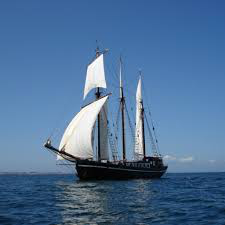

In [316]:
## test examples
from PIL import Image

PATH_ex = 'networks/network.pt'
netx = Network().cuda()
netx.load_state_dict(torch.load(PATH_ex))
netx.eval()


imsize = 32
loader_ex = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])

image = Image.open('images/image3.jpg')   ## image directory goes here __
#x = TF.to_grayscale(image)
x = loader_ex(image)
idx = netx(x.unsqueeze(0).cuda()).argmax(dim = 1)[0]
print(classes[idx])
image